# Tree-based models - CART

In this section we will discuss the use of CART (**C**lassification **A**nd **R**egression **T**rees) and more specifically, we will use regression trees to predict claim frequencies.

In [11]:
# require("CASdatasets") - Not necessary, as we saved the data as parquet file
if (!require("rpart")) install.packages("rpart")
if (!require("rpart.plot")) install.packages("rpart.plot")
if (!require("arrow")) install.packages("arrow")
if (!require("caret")) install.packages("caret")
if (!require("ggplot2")) install.packages("ggplot2")
if (!require("rattle")) install.packages("rattle")


require("rpart")
require("rpart.plot")
require("arrow")
require("caret")
require("ggplot2")
require("rattle")

options(repr.plot.width = 8, repr.plot.height = 6, repr.plot.res = 150);

In [12]:
dataset = read_parquet(file = "../data/dataset.parquet")

When performing machine learning, one way to assess the predictability of the model is to use *fresh* data, not used in the *learning* process and compute some metric. This is also a good way to check whether the model is overfitting the data.

In order to have *fresh* data available at a later stage, it is common to split the dataset into two:
 - a training set. This data is used to estimate/learn the model.
 - a test set. This data is used to check the performance of the model, once it has been learned.
 
The package *caret* provides a lot of helpful functions. One of them is *createDataPartition*. Let us now split the data into two pieces (80% - 20%), by relying on stratified sampling. We use stratified sampling to obtain a similar distribution of the number of claims in boths the training and the test set. 

In [13]:
set.seed(21)
in_training = createDataPartition(y = dataset$ClaimNb, times = 1, p = 0.8, list = FALSE)
training_set = dataset[in_training, ]
testing_set = dataset[-in_training, ]

Let us check the distribution of the variable *ClaimNb* among these two groups.

In [14]:
temp = dataset
temp$training = NA
temp[in_training, "in_train_set"] = 1
temp[-in_training, "in_train_set"] = 0

summary_table = 100*round(prop.table(with(temp, table(in_train_set, ClaimNb)), 1), 5)
summary_table
rm(temp)

            ClaimNb
in_train_set      0      1      2      3      4
           0 96.316  3.502  0.174  0.006  0.001
           1 96.254  3.562  0.176  0.007  0.001

## Package CART

We will use the package CART which allows to compute regression trees. rpart can be used for regression and classification. It also implements a method for *Poisson* data.

### Quick Example

Let us start with a simple example, using two covariates:



In [5]:
m0_rpart = rpart(cbind(Exposure, ClaimNb) ~ DriverAge + CarAge, 
                 data = training_set,
                 method = "poisson", 
                 control = rpart.control(cp = 0.01))
summary(m0_rpart)

Call:
rpart(formula = cbind(Exposure, ClaimNb) ~ DriverAge + CarAge, 
    data = training_set, method = "poisson", control = rpart.control(cp = 0.01))
  n= 328692 

           CP nsplit rel error xerror xstd
1 0.006462633      0         1      0    0

Node number 1: 328692 observations
  events=12944,  estimated rate=0.07025564 , mean deviance=0.256468 



It appears that the tree has a single node and has not been split further. This comes from the complexity parameter which penalizes the splitting. **By default**, the complexity parameter **cp = 0.01**, which is often too large for Poisson data with low frequencies.

Let us put **cp = 0**, but to keep a small tree we will also impose a maximum depth of 3.

In [16]:
m0_rpart = rpart(cbind(Exposure, ClaimNb) ~ DriverAge + CarAge, 
                 data = training_set,
                 control = rpart.control(cp = 0, maxdepth = 3))
summary(m0_rpart)

Call:
rpart(formula = cbind(Exposure, ClaimNb) ~ DriverAge + CarAge, 
    data = training_set, control = rpart.control(cp = 0, maxdepth = 3))
  n= 328692 

            CP nsplit rel error    xerror        xstd
1 0.0064626327      0 1.0000000 1.0000301 0.006849965
2 0.0013751350      1 0.9935374 0.9942535 0.006792489
3 0.0011573505      2 0.9921622 0.9933192 0.006788764
4 0.0006268552      3 0.9910049 0.9919102 0.006781355
5 0.0003327416      4 0.9903780 0.9912190 0.006774532
6 0.0003102204      5 0.9900453 0.9910893 0.006773665
7 0.0001005746      6 0.9897351 0.9905608 0.006767532
8 0.0000000000      7 0.9896345 0.9906839 0.006769689

Variable importance
DriverAge    CarAge 
       88        12 

Node number 1: 328692 observations,    complexity param=0.006462633
  events=12944,  estimated rate=0.07025564 , mean deviance=0.256468 
  left son=2 (302869 obs) right son=3 (25823 obs)
  Primary splits:
      DriverAge < 26.5 to the right, improve=544.79390, (0 missing)
      CarAge    < 12.

The easiest way to interpret a CART is probably to plot it (if it is not too large, though!). This can be achieved with the function *rpart.plot* from the package *rpart.plot*.

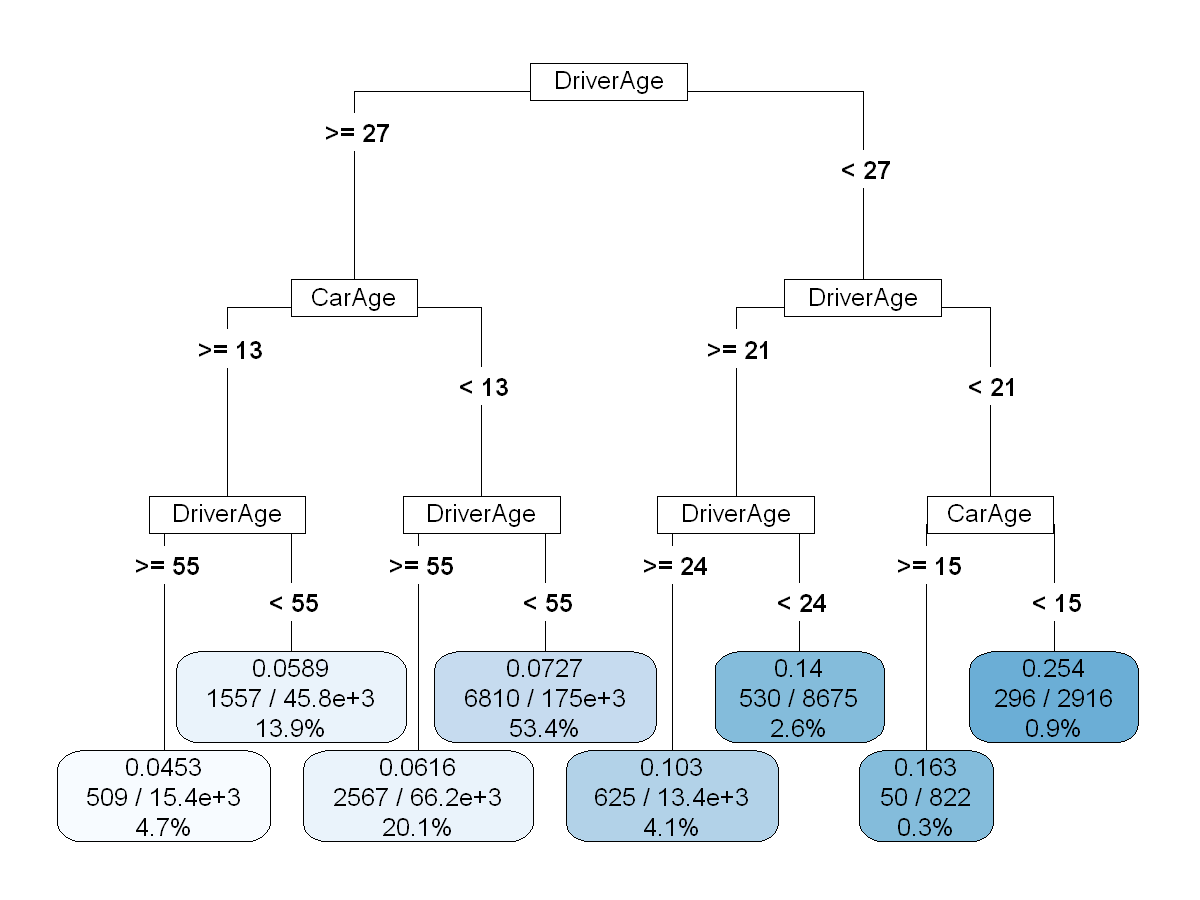

In [17]:
rpart.plot(m0_rpart, 
           type = 5, 
           extra = 101, 
           under = FALSE, 
           fallen.leaves = TRUE,
           digits = 3)

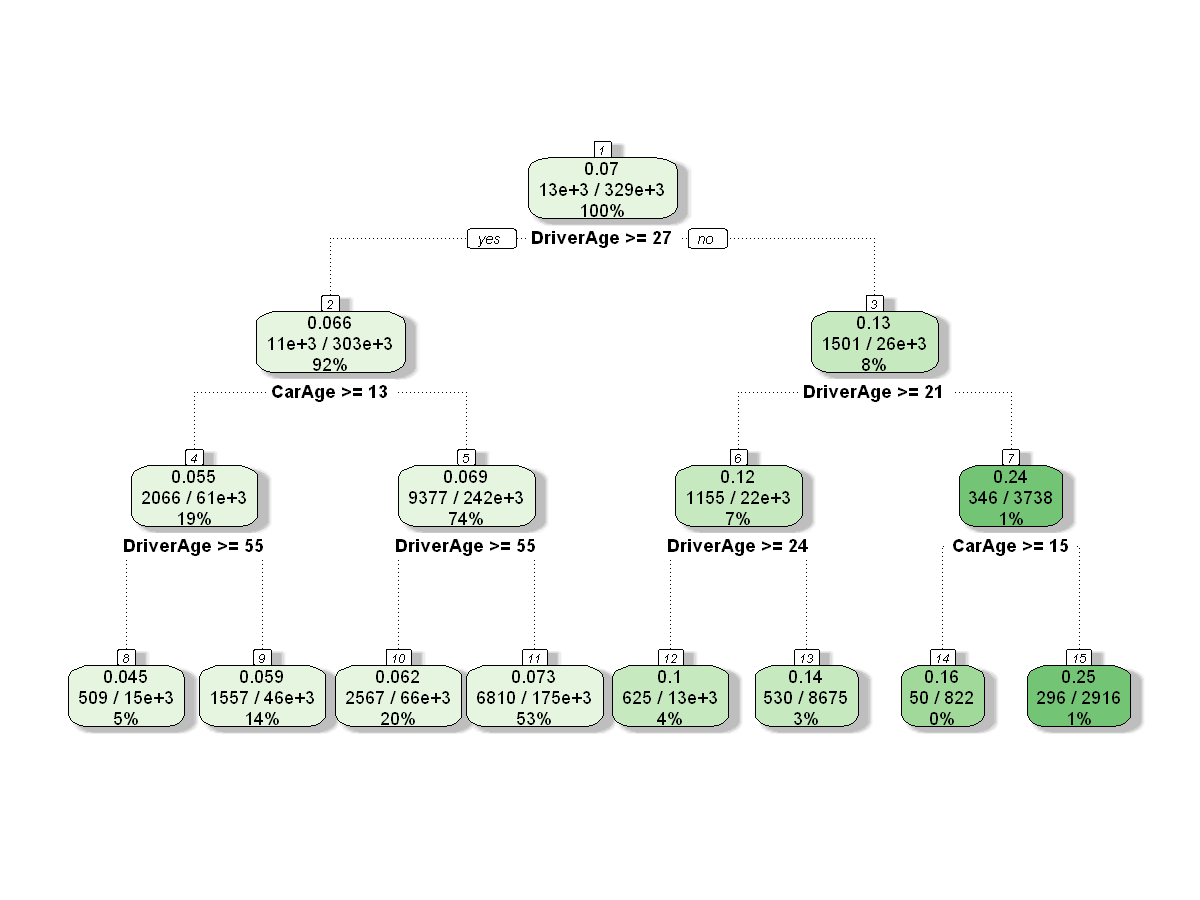

In [18]:
# For information - Or using the rattle package

fancyRpartPlot(m0_rpart, split.col="black",nn.col="black", 
               caption="", digits=2)

If the tree is too large, we will probably have some overfitting. To prevent overfitting, we can play with the complexity parameter cp. A good approach is to compute the whole tree, without any penalty (i.e. complexity parameter is set to 0) and afterwards prune to tree.

Warning message:
"labs do not fit even at cex 0.15, there may be some overplotting"


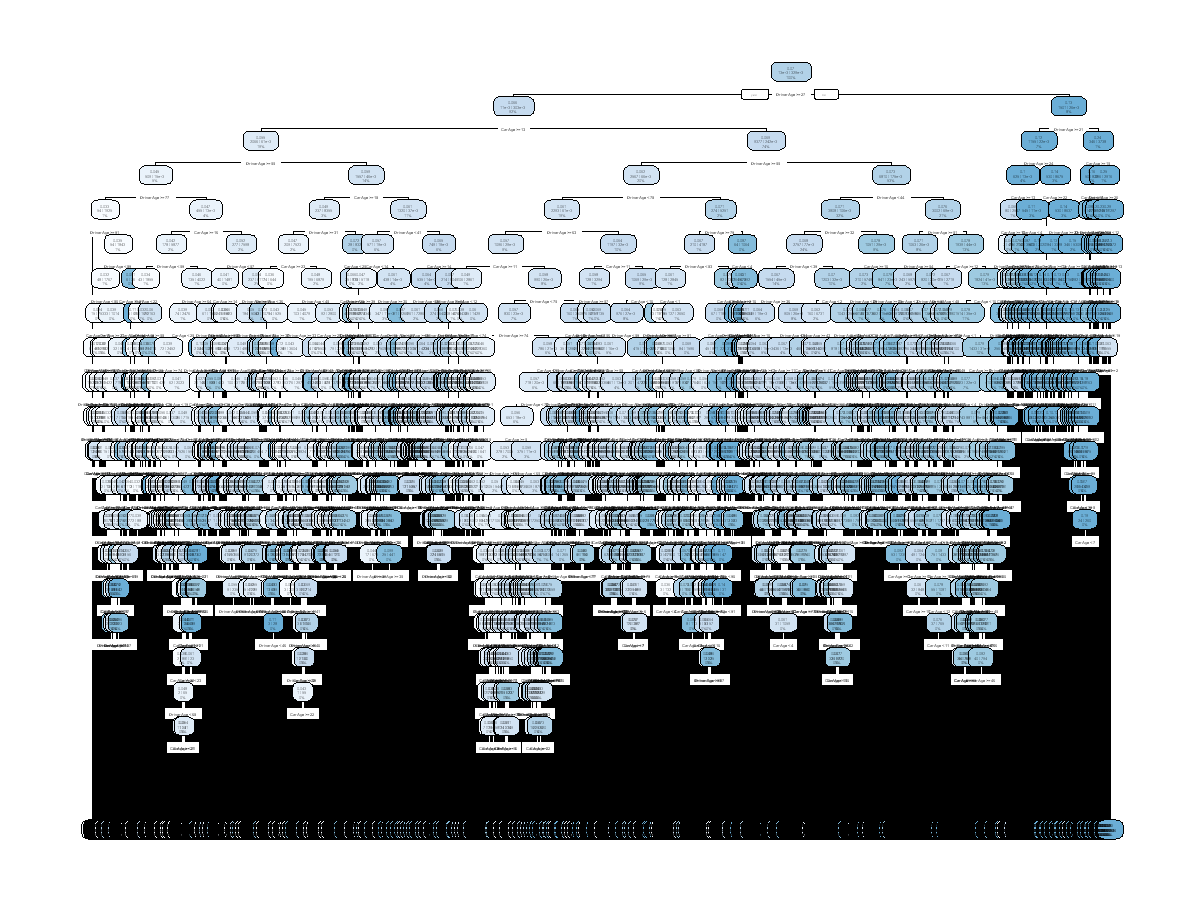

In [19]:
m0_rpart = rpart(cbind(Exposure, ClaimNb) ~ DriverAge + CarAge, 
                 data = training_set,
                 control = rpart.control(cp = 0))
rpart.plot(m0_rpart)

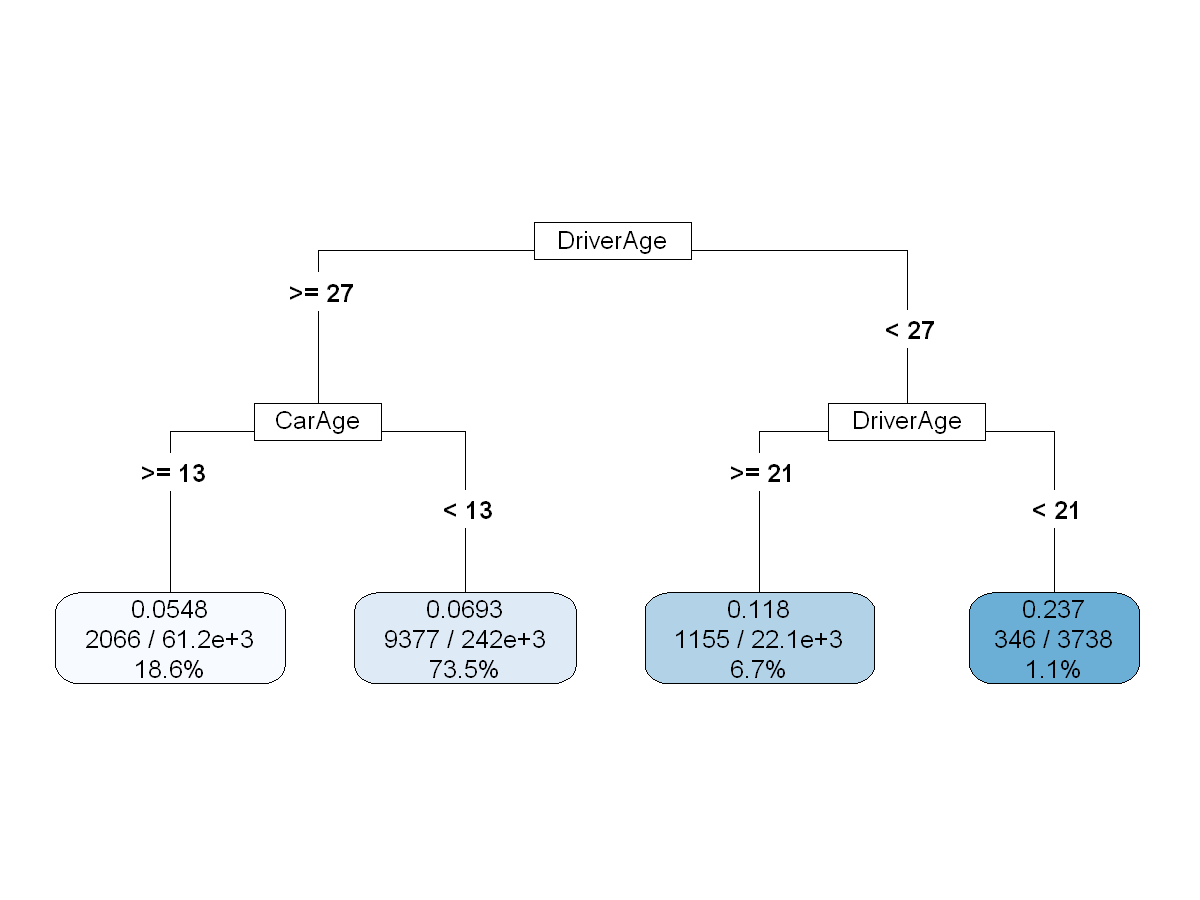

In [10]:
rpart.plot(prune(m0_rpart, cp = 9e-04), 
           type = 5, 
           extra = 101, 
           under = FALSE, 
           fallen.leaves = TRUE,
           digits = 3)

We also see that in some terminal nodes (i.e. leaves), the number of observations (and of claims) is very low. We can set a minimum number of observation in any terminal node using minbucket

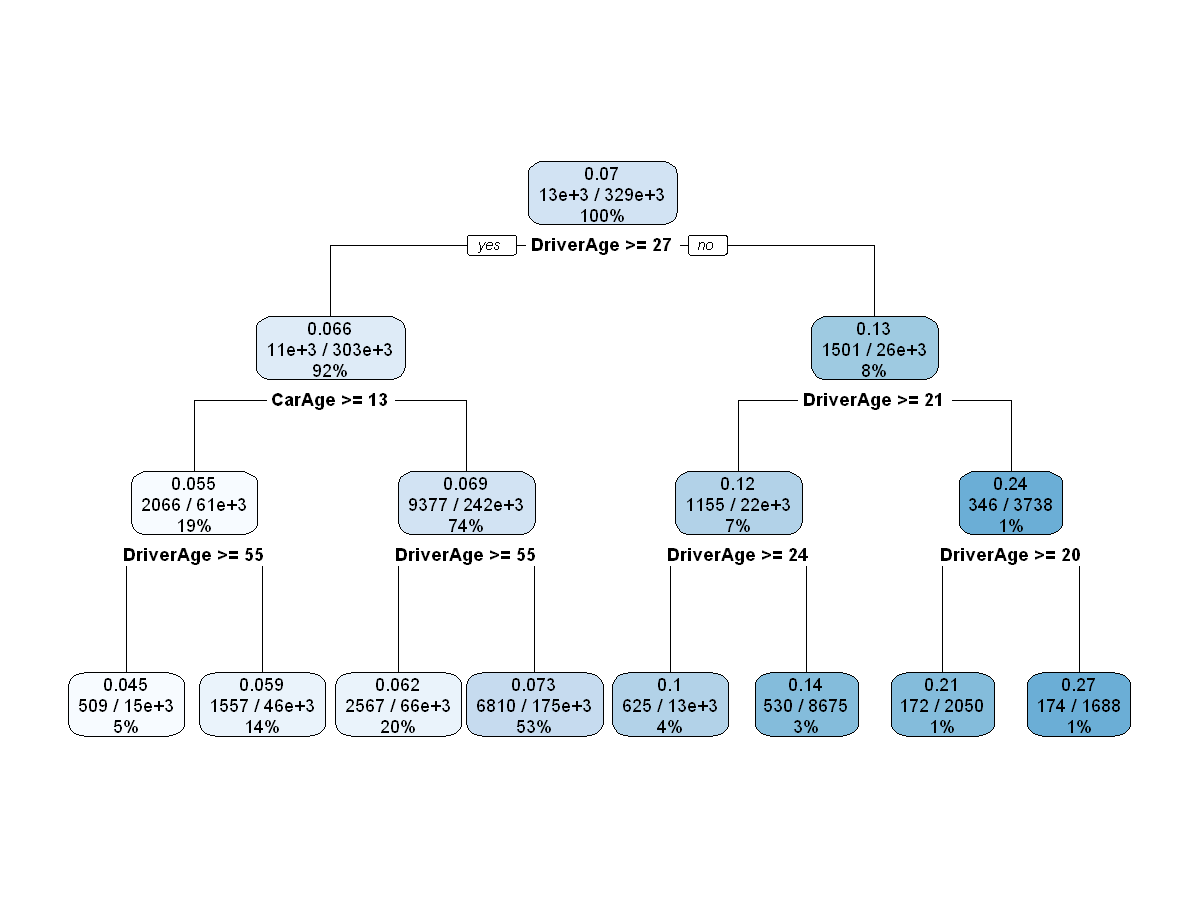

In [11]:
m0_rpart = rpart(cbind(Exposure, ClaimNb) ~ DriverAge + CarAge, 
                 data = training_set,
                 control = rpart.control(cp = 0, maxdepth = 3, minbucket = 1000))
rpart.plot(m0_rpart)

## Complexity Parameter

Playing around with the complexity parameter will yield sub-trees of the fully developped tree (i.e. the one with cp = 0).

We check on one example that increasing the complexity parameter *cp* will only prune the tree differently and that by increasing *cp*, we will obtain a **subtree**. The common parts of the three trees below (i.e., the first split) are identical.

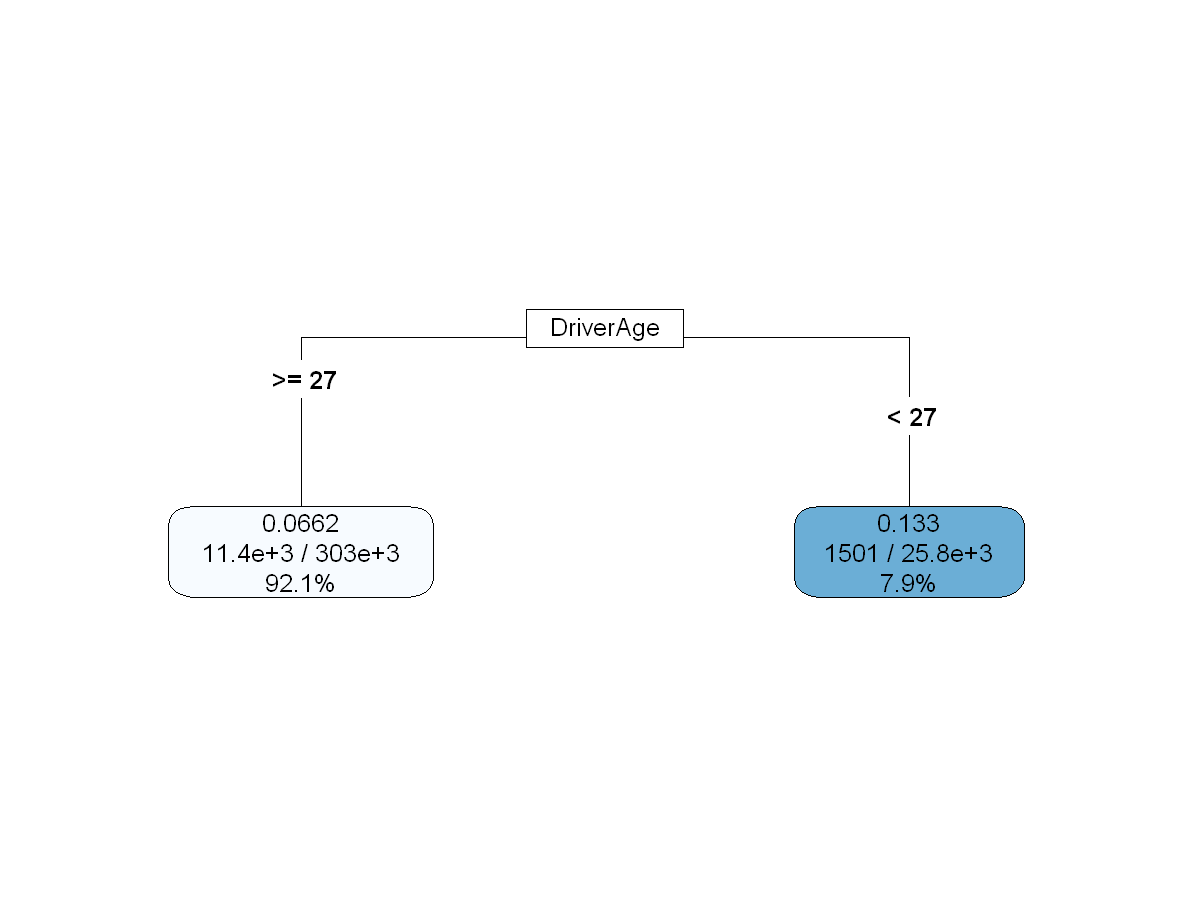

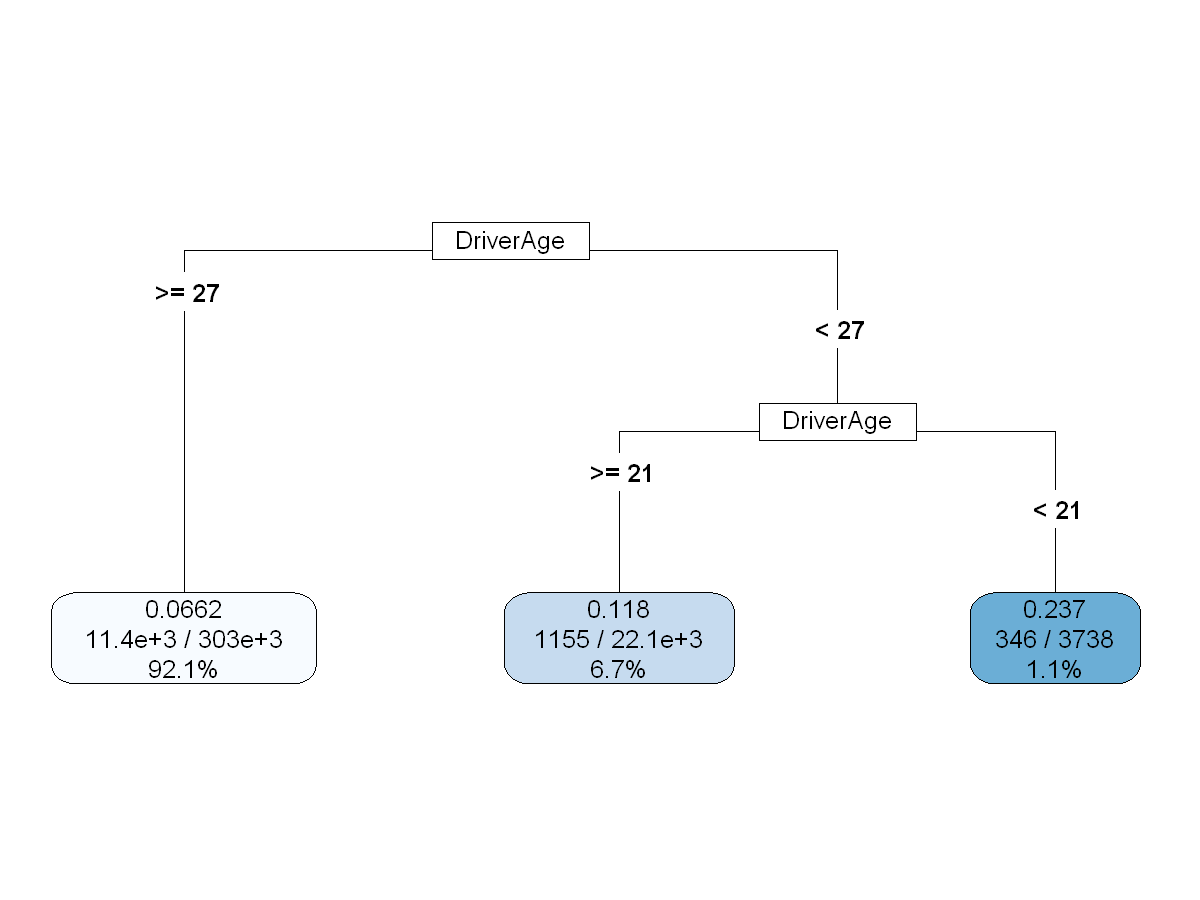

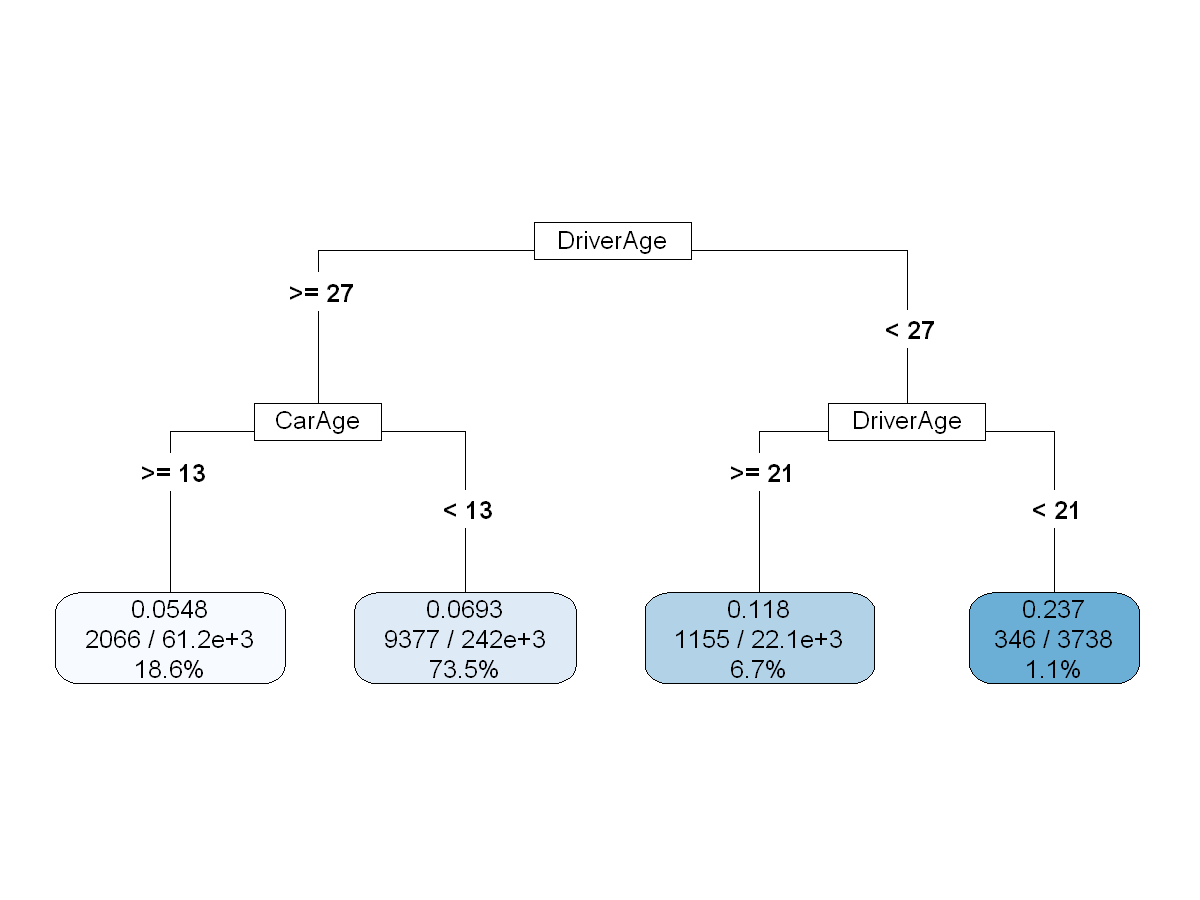

In [21]:
tree1 = rpart(cbind(Exposure, ClaimNb) ~ DriverAge + CarAge, 
                 data = training_set,
                 control = rpart.control(cp = 0.0063))
rpart.plot(tree1,
           type = 5, 
           extra = 101, 
           under = FALSE, 
           fallen.leaves = TRUE,
           digits = 3)

tree2 = rpart(cbind(Exposure, ClaimNb) ~ DriverAge + CarAge, 
                 data = training_set,
                 control = rpart.control(cp = 0.0013))
rpart.plot(tree2,
           type = 5, 
           extra = 101, 
           under = FALSE, 
           fallen.leaves = TRUE,
           digits = 3)


tree3 = rpart(cbind(Exposure, ClaimNb) ~ DriverAge + CarAge, 
                 data = training_set,
                 control = rpart.control(cp = 0.0011))
rpart.plot(tree3,
           type = 5, 
           extra = 101, 
           under = FALSE, 
           fallen.leaves = TRUE,
           digits = 3)

## Cross-validation

Let us now find the optimal tree, by using cross-validation. We will again only use the variable DriverAge and CarAge in this section. By default, rpart will perform 10-fold cross-validation, using the option xval = 10. (Remark: The whole process of how the cross-validation is operated in described in Section 4.2 of rpart’s vignette: https://cran.r-project.org/web/packages/rpart/vignettes/longintro.pdf).

Essentially (and with some shortcuts), we can summarize the method as follows:

1. Estimate the full tree (cp = 0), on the whole data. We obtain a list of complexity parameters $\alpha_i$. We compute the $\beta$s are the geometric mean of two successive $\alpha_i$s. To each $\beta_i$ corresponds a subtree of the full tree.
2. Split the whole data into *folds* (generally 10 folds).
    - Estimate the tree using all folds but one. 
    - Using the list of $\beta_i$s from the previous step, we prune the tree to differents subtrees.
    - Compute the loss function ("risk") of these subtrees on the left-out fold. For each $\beta_i$ we obtain a loss.
    - Loop on the folds. We obtain for each $\beta_i$ as many losses as there are folds. We aggregate these losses by summing.
    - After agregation, for each $\beta_i$ we have a single loss.
3. The optimal complexity parameter $cp^*$ is defined as the $\beta_i$ with the smallest loss (see remark below). The optimal tree is defined as the subtree with cp = $cp^*$

Remark: We may also use the 1-SE rule, which will yield the largest $\beta_i$ whose corresponding loss is in the 1-standard error window of the smallest loss.

In [23]:
m0_rpart = rpart(cbind(Exposure, ClaimNb) ~ DriverAge + CarAge, 
                 data = training_set,
                 control = rpart.control(
                             cp = 3e-5, 
                             xval = 10))
printcp(m0_rpart)


Rates regression tree:
rpart(formula = cbind(Exposure, ClaimNb) ~ DriverAge + CarAge, 
    data = training_set, control = rpart.control(cp = 3e-05, 
        xval = 10))

Variables actually used in tree construction:
[1] CarAge    DriverAge

Root node error: 84299/328692 = 0.25647

n= 328692 

           CP nsplit rel error  xerror      xstd
1  6.4626e-03      0   1.00000 1.00003 0.0068502
2  1.3751e-03      1   0.99354 0.99405 0.0067910
3  1.1574e-03      2   0.99216 0.99303 0.0067860
4  6.2686e-04      3   0.99100 0.99207 0.0067808
5  3.3274e-04      4   0.99038 0.99075 0.0067667
6  3.1022e-04      5   0.99005 0.99062 0.0067664
7  2.1284e-04      6   0.98974 0.99037 0.0067648
8  1.4038e-04      7   0.98952 0.99020 0.0067625
9  1.2139e-04      8   0.98938 0.99049 0.0067675
10 1.2074e-04      9   0.98926 0.99041 0.0067661
11 1.0057e-04     11   0.98902 0.99052 0.0067678
12 9.6270e-05     12   0.98892 0.99076 0.0067708
13 8.4053e-05     15   0.98863 0.99066 0.0067695
14 8.1808e-05     1

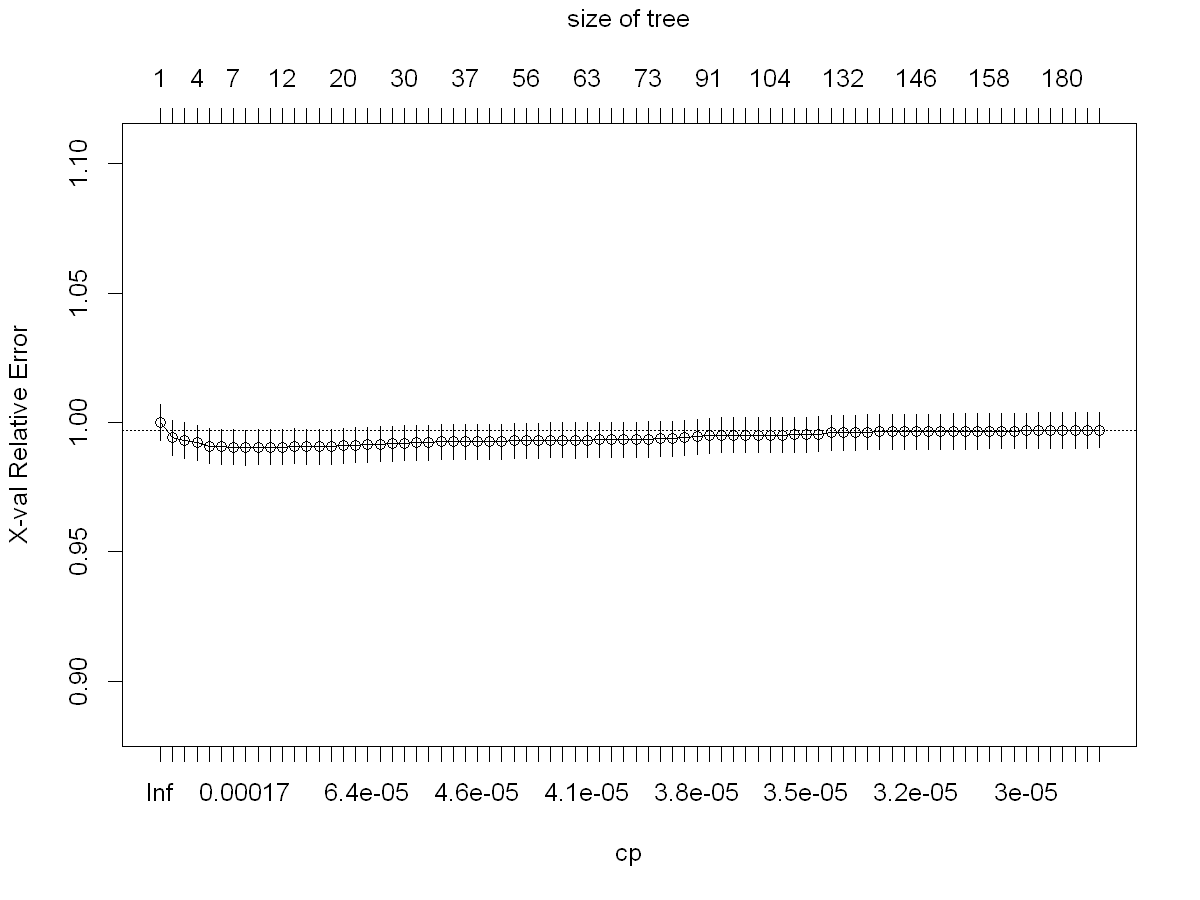

In [24]:
plotcp(m0_rpart)

In [15]:
head(m0_rpart$cptable, 10)

,CP,nsplit,rel error,xerror,xstd
1,0.0064626327,0,1.0000000,1.0000168,0.006849957
2,0.0013751350,1,0.9935374,0.9940596,0.006790466
3,0.0011573505,2,0.9921622,0.9932782,0.006788058
4,0.0006268552,3,0.9910049,0.9920008,0.006780117
5,0.0003327416,4,0.9903780,0.9906550,0.006766619
6,0.0003102204,5,0.9900453,0.9905832,0.006766865
7,0.0002128410,6,0.9897351,0.9902226,0.006762557
8,0.0001403828,7,0.9895222,0.9902105,0.006762889
9,0.0001213919,8,0.9893818,0.9904293,0.006766246
10,0.0001207448,9,0.9892604,0.9904439,0.006765741


Let us see the optimal tree.

[1] 0.0001403828


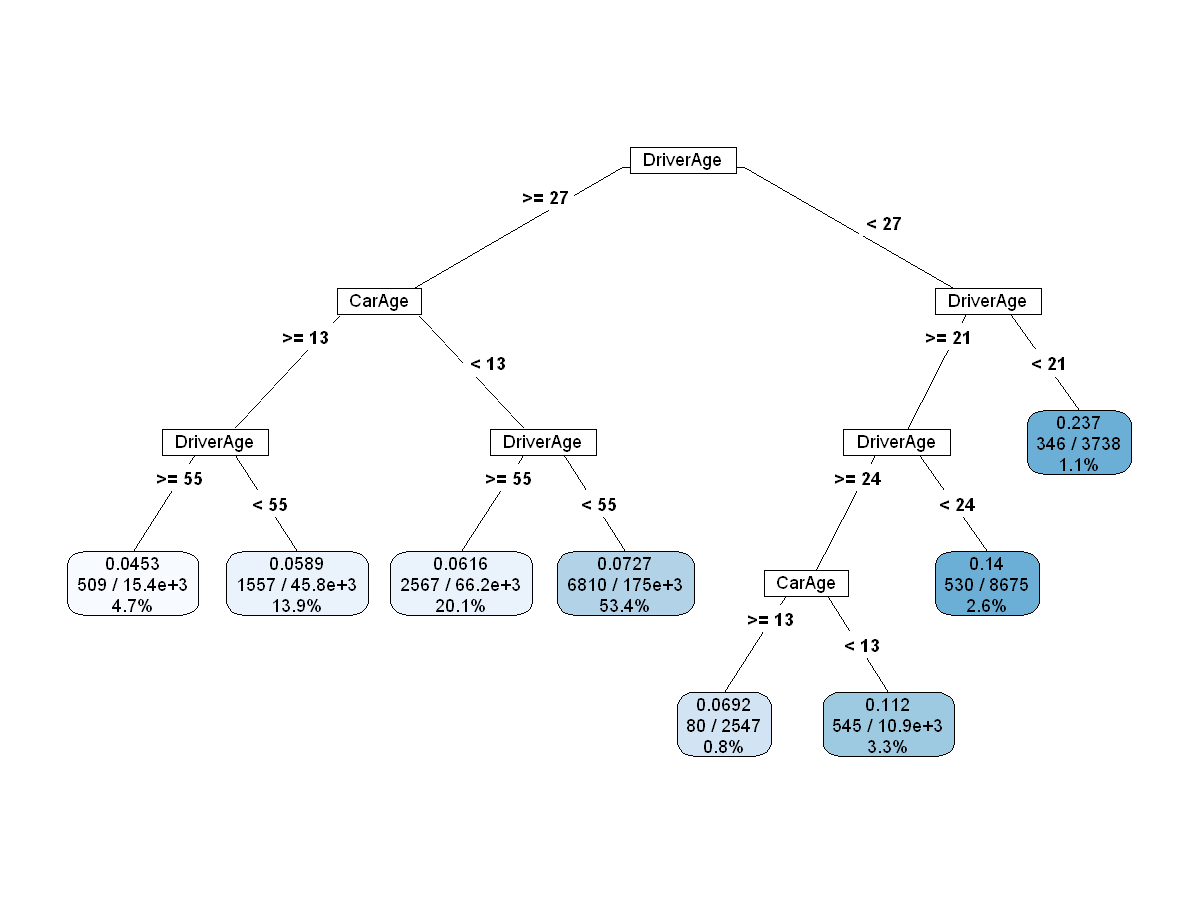

In [25]:
cp_star = m0_rpart$cptable[which.min(m0_rpart$cptable[,"xerror"]), "CP"]
print(cp_star)

rpart.plot(prune(m0_rpart, cp = cp_star), type = 5, extra = 101, under = FALSE, fallen.leaves = FALSE,
    digits = 3)

Using the 1-SE error rule, we need to compute the greatest cp parameters that enters the 1-SE window

[1] 0.9969665

[1] 0.001375135


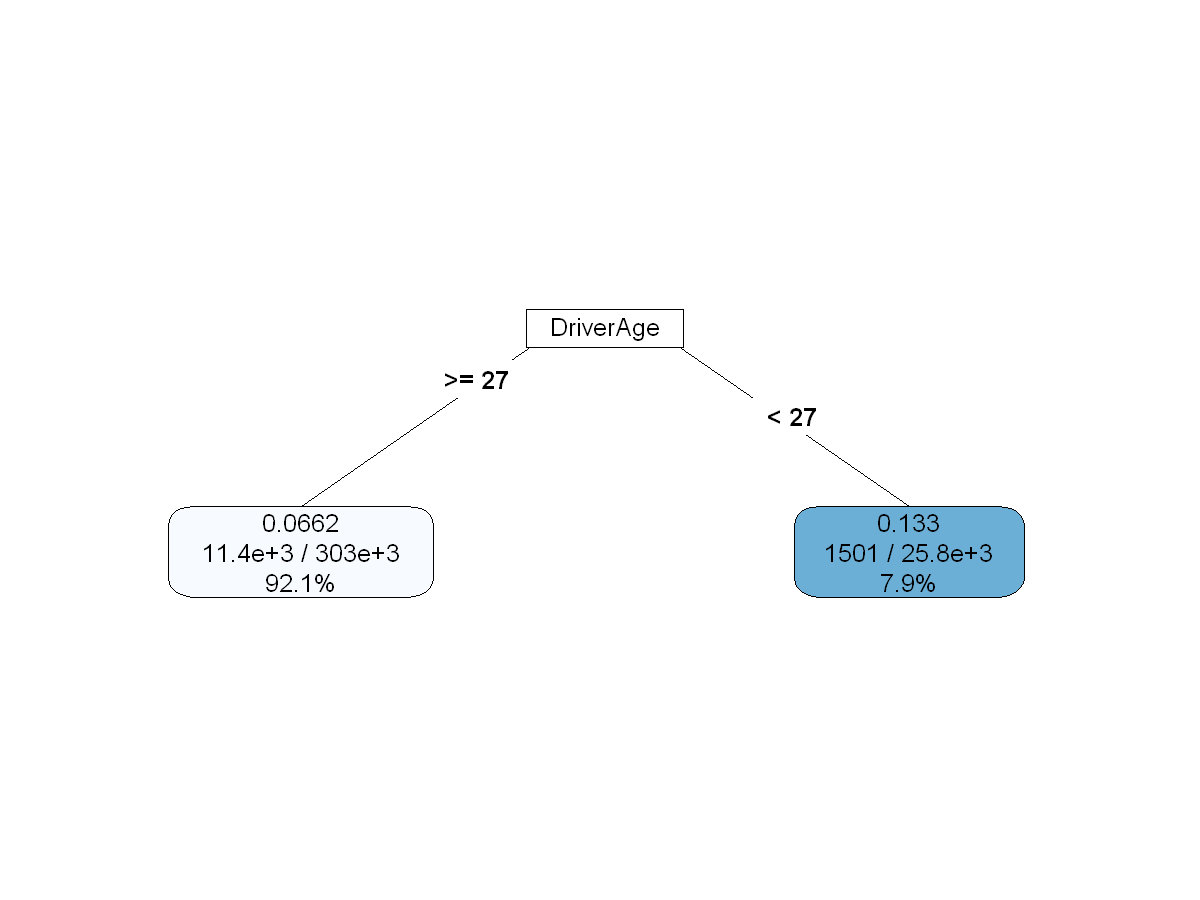

In [26]:
SE = m0_rpart$cptable[which.min(m0_rpart$cptable[, 4]), 5]
min_error = m0_rpart$cptable[which.min(m0_rpart$cptable[, 4]), 4]
boundary = min_error + SE
boundary

# We need to find the first cp such that xerror < boundary.
row_optimal = which(m0_rpart$cptable[, 4] < boundary)[1]
cp_star = m0_rpart$cptable[row_optimal, 1]
print(cp_star)

rpart.plot(prune(m0_rpart, cp = cp_star), type = 5, extra = 101, under = FALSE, fallen.leaves = FALSE,
    digits = 3)

## Using all covariates

Let us now include all the covariates from the dataset

In [27]:
m1_rpart = rpart(cbind(Exposure, ClaimNb) ~ Power + CarAge + DriverAge + Brand +
    Gas + Region + Density, data = training_set, method = "poisson", control = rpart.control(cp = 0,
    xval = 10, minbucket = 1000))
printcp(m1_rpart)


Rates regression tree:
rpart(formula = cbind(Exposure, ClaimNb) ~ Power + CarAge + DriverAge + 
    Brand + Gas + Region + Density, data = training_set, method = "poisson", 
    control = rpart.control(cp = 0, xval = 10, minbucket = 1000))

Variables actually used in tree construction:
[1] Brand     CarAge    Density   DriverAge Gas       Power     Region   

Root node error: 84299/328692 = 0.25647

n= 328692 

            CP nsplit rel error  xerror      xstd
1   6.4626e-03      0   1.00000 1.00003 0.0068500
2   4.3514e-03      1   0.99354 0.99433 0.0067920
3   1.3751e-03      2   0.98919 0.99023 0.0067534
4   8.3749e-04      3   0.98781 0.98941 0.0067506
5   6.8456e-04      4   0.98697 0.98823 0.0067465
6   5.2298e-04      5   0.98629 0.98754 0.0067438
7   4.7610e-04      6   0.98577 0.98780 0.0067457
8   4.4572e-04      7   0.98529 0.98762 0.0067439
9   3.8233e-04      8   0.98484 0.98713 0.0067388
10  2.9440e-04      9   0.98446 0.98698 0.0067367
11  2.8062e-04     10   0.98417 0.

In [29]:
summary(m1_rpart)

Call:
rpart(formula = cbind(Exposure, ClaimNb) ~ Power + CarAge + DriverAge + 
    Brand + Gas + Region + Density, data = training_set, method = "poisson", 
    control = rpart.control(cp = 0, xval = 10, minbucket = 1000))
  n= 328692 

              CP nsplit rel error    xerror        xstd
1   6.462633e-03      0 1.0000000 1.0000320 0.006849996
2   4.351429e-03      1 0.9935374 0.9943298 0.006791992
3   1.375135e-03      2 0.9891859 0.9902348 0.006753353
4   8.374902e-04      3 0.9878108 0.9894103 0.006750577
5   6.845649e-04      4 0.9869733 0.9882321 0.006746543
6   5.229841e-04      5 0.9862887 0.9875436 0.006743793
7   4.760996e-04      6 0.9857658 0.9877986 0.006745701
8   4.457216e-04      7 0.9852897 0.9876243 0.006743867
9   3.823344e-04      8 0.9848439 0.9871273 0.006738774
10  2.944036e-04      9 0.9844616 0.9869815 0.006736688
11  2.806235e-04     10 0.9841672 0.9866777 0.006734145
12  2.716628e-04     11 0.9838866 0.9864631 0.006733874
13  2.186037e-04     12 0.9836149 0

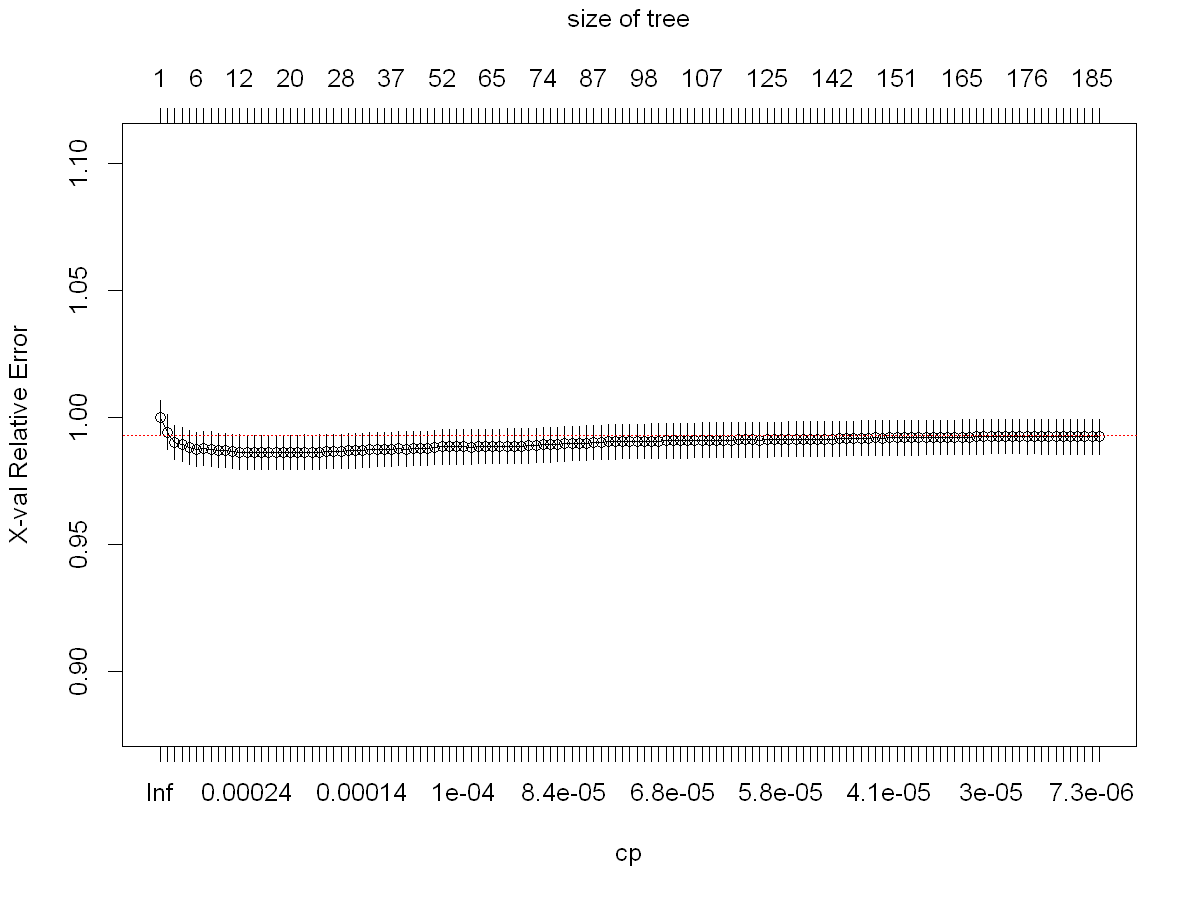

In [28]:
plotcp(x = m1_rpart, minline = TRUE, col = "red")

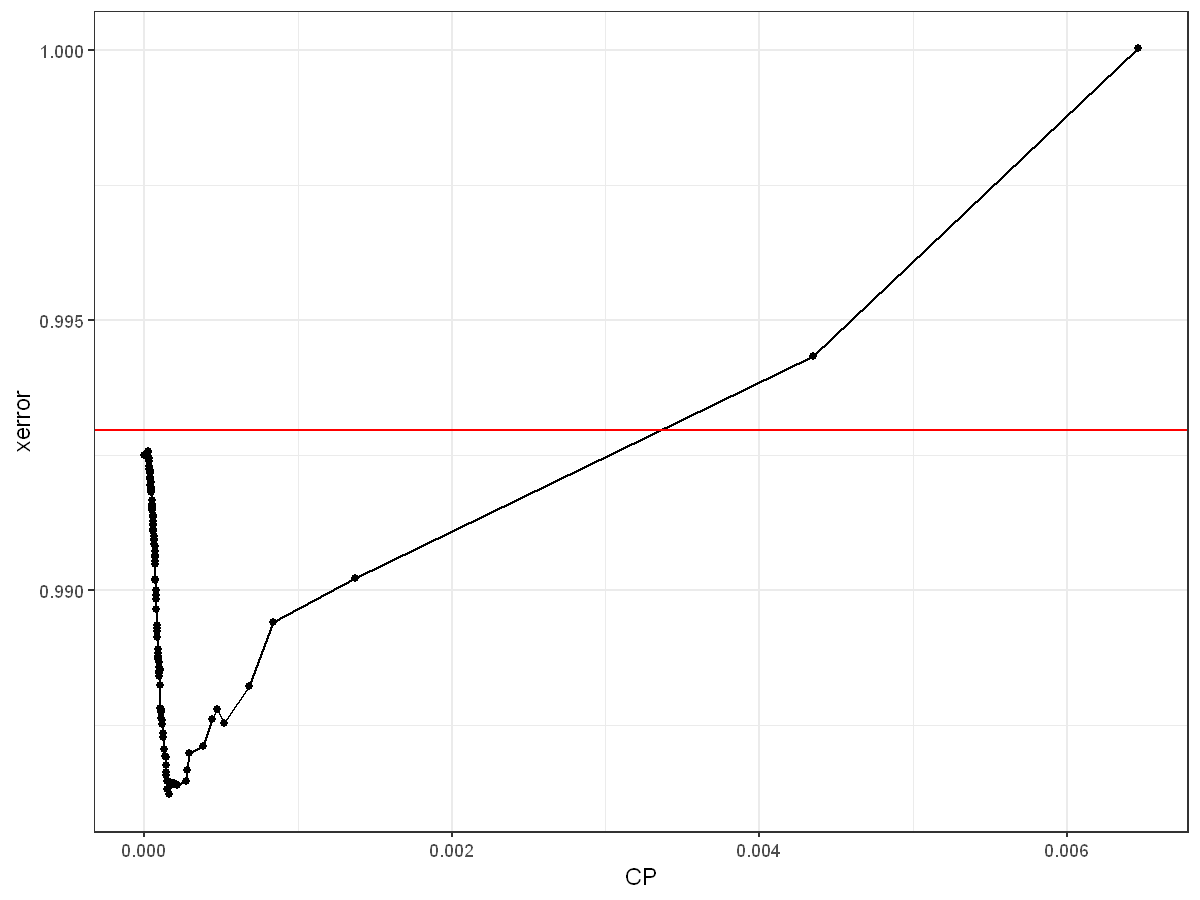

In [30]:
# Compute boundary for 1SE-rule
SE = m1_rpart$cptable[which.min(m1_rpart$cptable[, 4]), 5]
min_error = m1_rpart$cptable[which.min(m1_rpart$cptable[, 4]), 4]
boundary = min_error + SE

# Plot cross-validation error and 1SE_rule boundary.
ggplot() + geom_line(aes(x = m1_rpart$cptable[, 1], y = m1_rpart$cptable[, 4]))+
geom_point(aes(x = m1_rpart$cptable[, 1], y = m1_rpart$cptable[, 4]))+
geom_hline(aes(yintercept = boundary), color="red")+
scale_x_continuous(name = "CP") + scale_y_continuous(name = "xerror") + theme_bw()

If we take the value of cp that minimizes the error, we find

In [31]:
# A verifier
cp_star = m1_rpart$cptable[which.min(m1_rpart$cptable[, 4]), 1]
cp_star

[1] 0.000162682

Let us plot the optimal tree

Warning message:
"labs do not fit even at cex 0.15, there may be some overplotting"


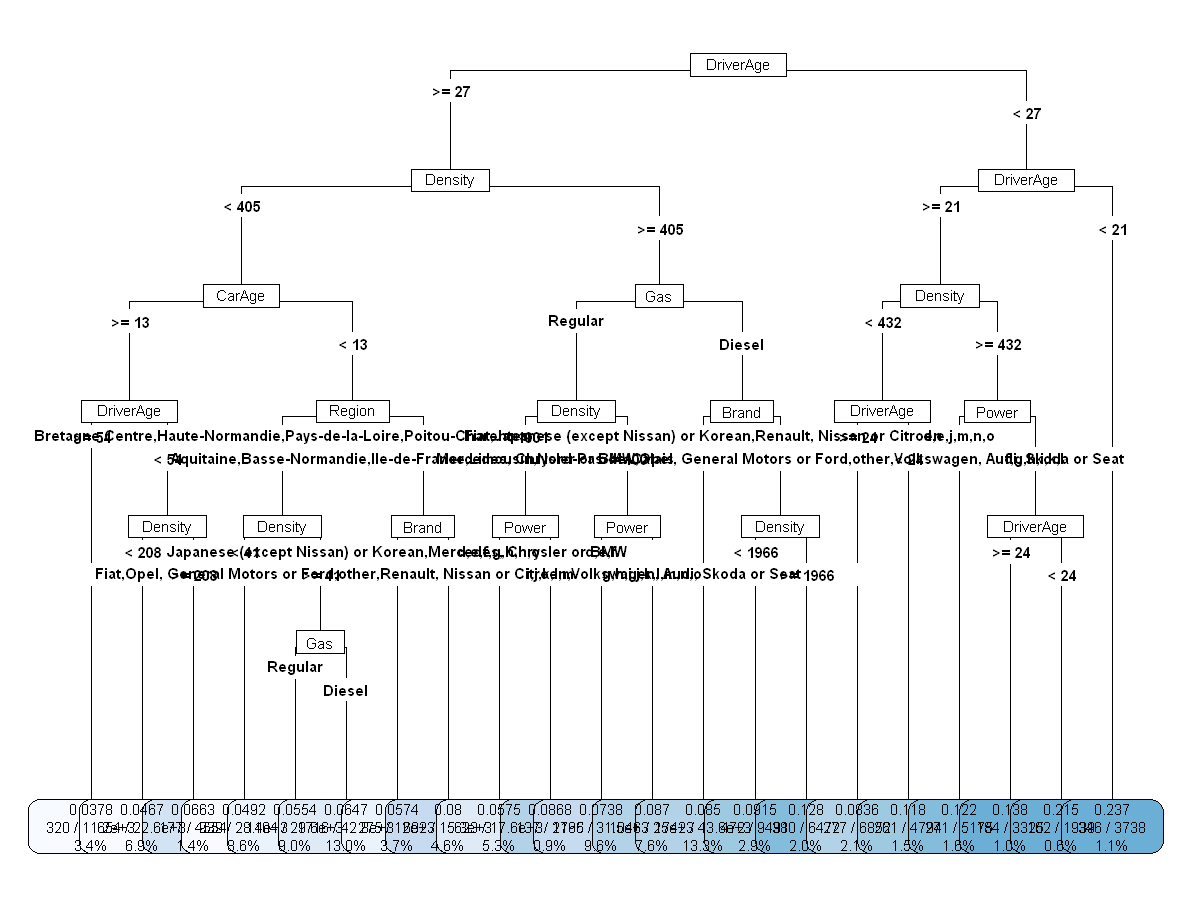

In [32]:
m2_rpart = prune(m1_rpart, cp = cp_star)
rpart.plot(m2_rpart, type = 5, extra = 101, under = FALSE, fallen.leaves = TRUE,
    digits = 3, cex = 0.60)

There is a possibility to extract a variable importance metric.

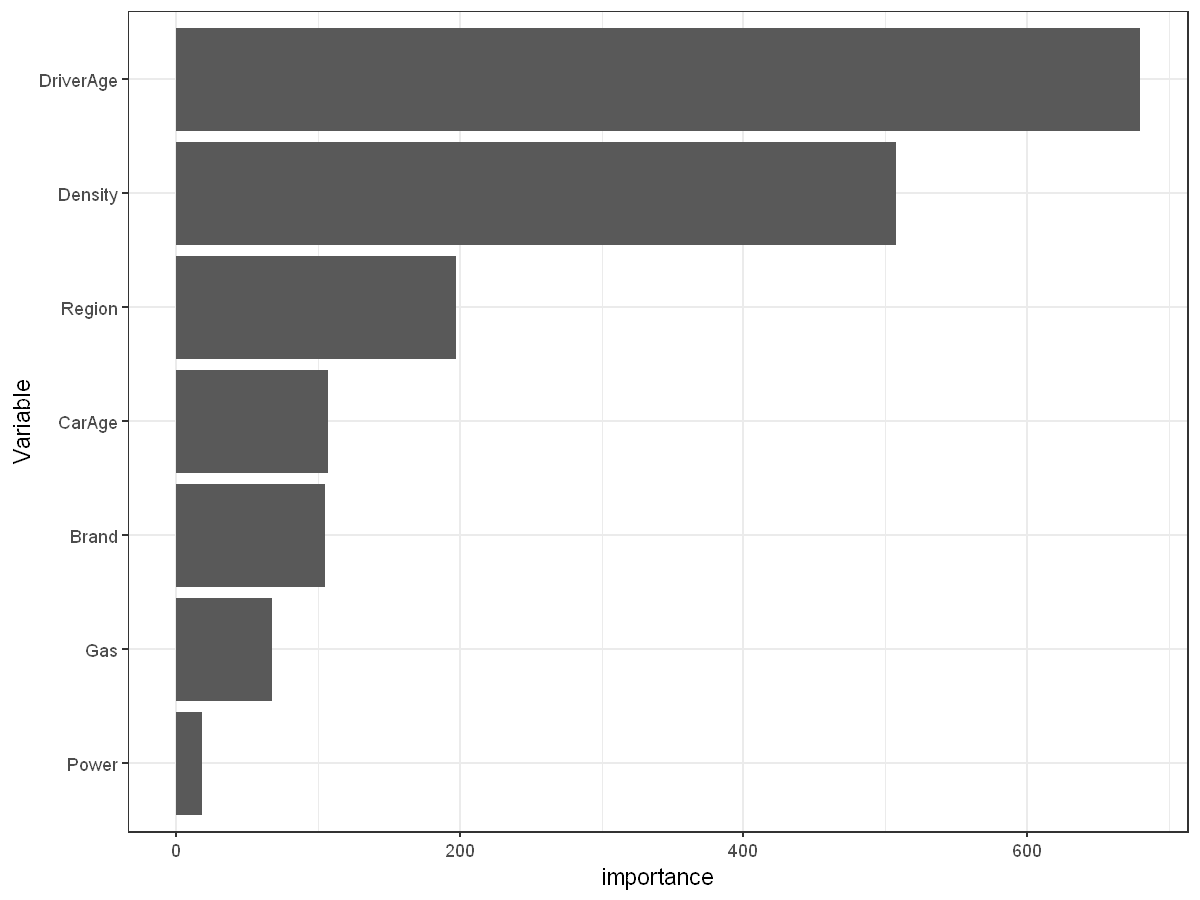

In [23]:
plotdata = data.frame(m2_rpart$variable.importance)
names(plotdata) = 'importance'
plotdata$var = rownames(plotdata)

ggplot(plotdata,aes(x =reorder(var,importance), y=importance)) + 
geom_bar(stat='identity')+coord_flip()+
scale_x_discrete(name="Variable") + 
theme_bw()

Finally, let us compute the deviance on the testing_set.

In [34]:
deviance_poisson = function(x_obs, x_pred) {
    2 * (sum(dpois(x = x_obs, lambda = x_obs, log = TRUE)) - sum(dpois(x = x_obs,
        lambda = x_pred, log = TRUE)))
}

deviance_poisson(x_obs = testing_set$ClaimNb, x_pred = predict(m2_rpart, testing_set) *
    testing_set$Exposure)

[1] 20491.05

If we compute the deviance on the full tree (not the pruned tree), we obtain

In [35]:
deviance_poisson(x_obs = testing_set$ClaimNb, x_pred = predict(m1_rpart, testing_set) *
    testing_set$Exposure)

[1] 20661.82

## Bagging of trees

Let us create the bootstrap samples.

In [36]:
set.seed(85)
bootstrap_samples = createResample(training_set$ClaimNb, times = 50)

For each sample, we estimate a CART with the optimal complexity parameter found previously. Each tree, gives us an estimation of the claim frequency, which we average.

In [38]:
bagg_cart = lapply(bootstrap_samples, function(X) {
    rpart(cbind(Exposure, ClaimNb) ~ Power + CarAge + DriverAge + Brand + Gas + Region + Density, 
          data = training_set[X, ], 
          method = "poisson", 
          control = rpart.control(cp = cp_star,
                                  xval = 0))
})

In [41]:
pred = lapply(bagg_cart, function(X) {
    predict(X, testing_set) * testing_set$Exposure
})

pred = do.call(cbind, pred)
pred

,Resample01,Resample02,Resample03,Resample04,Resample05,Resample06,Resample07,Resample08,Resample09,Resample10,...,Resample41,Resample42,Resample43,Resample44,Resample45,Resample46,Resample47,Resample48,Resample49,Resample50
1,0.0051257371,0.009003066,0.0075612861,0.006301093,0.0071756994,0.005576000,0.0030516406,0.006552491,0.007780928,0.005207384,...,0.004182110,0.0065125585,0.004450266,0.005484138,0.005897032,0.007100210,0.0069099093,0.0074654515,0.006697976,0.006459939
8,0.0068443152,0.003801310,0.0024334074,0.001447093,0.0023550405,0.001482444,0.0030066753,0.001449570,0.003290140,0.002282997,...,0.002871682,0.0005128061,0.002810118,0.001349941,0.003047982,0.002913714,0.0032530745,0.0015864934,0.002254373,0.002512996
9,0.1122448096,0.311732448,0.1066306879,0.095207595,0.1073443348,0.166177432,0.0923603135,0.060657908,0.076064110,0.131534488,...,0.036056363,0.0924744028,0.055454884,0.100465844,0.092078313,0.113404840,0.0723612073,0.0289481406,0.024643697,0.088496986
14,0.0081580146,0.008162952,0.0127790596,0.013573147,0.0019752169,0.011254811,0.0112692586,0.005508365,0.006312578,0.014112083,...,0.007883478,0.0101181584,0.010237124,0.028542663,0.008622864,0.011072112,0.0138630749,0.0186922841,0.009806203,0.009549383
19,0.0105448031,0.011702402,0.0098329205,0.011283047,0.0108191571,0.007108301,0.0090926336,0.009781973,0.007669794,0.011656219,...,0.011951837,0.0097375751,0.006465552,0.005984249,0.004120678,0.007305708,0.0097258707,0.0124815928,0.008269007,0.013396280
24,0.0643473598,0.213662754,0.0965383251,0.050720706,0.0640133463,0.141178208,0.0103141655,0.081800009,0.084853399,0.119776152,...,0.070715035,0.0576139861,0.088170420,0.042448014,0.070795006,0.043225437,0.3232009579,0.0738494238,0.048924958,0.045401166
28,0.0309145818,0.054019270,0.0484259101,0.051435083,0.0860565809,0.042649809,0.0899318810,0.053264120,0.047378022,0.053477369,...,0.053829610,0.0383424950,0.038793313,0.019439157,0.032676115,0.067500896,0.0318736840,0.1103480070,0.047027039,0.068767719
30,0.0436057375,0.038484885,0.0320803273,0.024682158,0.0420992538,0.048944892,0.0449551077,0.029458366,0.016033491,0.038518599,...,0.066940840,0.0571657911,0.039063444,0.048138548,0.051762833,0.041508437,0.0606536485,0.0403492319,0.032680095,0.042156519
33,0.0322026894,0.045416441,0.0614788201,0.070519044,0.0375034479,0.044426884,0.1441194067,0.051514689,0.047936211,0.010983890,...,0.029636908,0.0754359742,0.076327582,0.047207031,0.052984869,0.082460763,0.0332017542,0.0514967671,0.073847613,0.040776277
34,0.0405325655,0.047613189,0.0253156067,0.036669582,0.0627948337,0.057850569,0.0274647652,0.153105181,0.038165597,0.168908160,...,0.035292001,0.0404215843,0.052611715,0.077570998,0.064386629,0.035500357,0.0462265409,0.0357441677,0.050003214,0.035103917


In [42]:
pred = apply(pred, 1, mean)
pred

1            8            9           14           19           24 
5.790182e-03 2.670205e-03 9.682928e-02 1.041803e-02 8.609113e-03 7.046885e-02 
          28           30           33           34           38           49 
4.739583e-02 4.107322e-02 5.767252e-02 4.793968e-02 1.400245e-02 5.453510e-03 
          53           55           59           60           62           63 
3.742649e-02 9.705931e-04 1.083136e-02 7.942994e-03 2.925036e-02 6.607651e-03 
          65           79           94           97           98          104 
1.198119e-02 7.254713e-02 2.093247e-02 1.543963e-02 5.122272e-02 5.126122e-02 
         117          118          141          147          148          155 
6.001503e-02 2.222779e-03 4.069026e-03 1.039837e-02 1.261026e-02 1.033344e-02 
         157          159          167          168          169          173 
8.142359e-02 1.794306e-02 2.066579e-02 3.528306e-03 7.591007e-02 4.360089e-02 
         178          179          180          182          188          191 
9.013818e-03 2.906869e-02 1.465479e-02 9.117024e-02 2.329115e-02 1.047296e-02 
         196          198          205          209          224          225 
3.526599e-02 2.852983e-02 4.145221e-02 4.414267e-03 3.921989e-02 4.375741e-02 
         230          234          243          245          246          248 
1.446705e-02 5.311945e-02 4.481513e-03 3.674119e-02 1.630031e-02 2.537775e-02 
         251          264          270          271          273          276 
5.190903e-03 1.651224e-02 5.710273e-02 4.391809e-02 2.298193e-03 4.099947e-03 
         282          295          302          306          324          327 
1.973309e-02 6.092709e-02 4.904245e-02 2.660373e-02 2.474612e-02 1.022151e-02 
         335          337          351          355          358          363 
4.396815e-02 3.917495e-02 1.361522e-02 4.529322e-02 2.447898e-02 3.571311e-03 
         367          369          371          372          374          377 
1.687144e-02 9.793923e-03 6.837924e-02 2.772132e-03 3.643973e-02 3.613041e-02 
         378          386          402          410          411          417 
5.879873e-02 3.335163e-02 8.802151e-03 4.802610e-03 4.856316e-02 3.792207e-02 
         419          420          421          429          430          437 
8.219123e-03 5.091098e-02 5.240836e-03 5.026944e-02 5.130650e-04 5.583303e-02 
         447          459          462          471          480          487 
4.946133e-03 3.924797e-02 4.281167e-02 7.866277e-03 3.444014e-02 6.627144e-03 
         495          500          506          507          509          520 
3.462294e-02 8.065302e-02 4.487233e-03 2.809974e-03 2.809974e-03 3.970004e-02 
         527          547          551          552          553          558 
5.115466e-03 2.984429e-02 3.275253e-03 3.384428e-02 4.636354e-02 4.016730e-03 
         559          560          565          567          573          578 
6.949009e-03 5.472345e-02 1.844532e-03 3.443878e-02 8.364478e-03 7.260552e-03 
         584          591          602          605          608          613 
4.612756e-02 3.467902e-02 5.188505e-03 2.345398e-02 3.813129e-02 2.968408e-02 
         615          621          626          633          639          641 
5.627291e-02 5.058517e-02 1.559242e-02 5.638689e-03 3.658222e-04 4.686183e-03 
         645          649          650          651          657          658 
2.680431e-02 1.004683e-02 2.668305e-02 9.417548e-03 4.384755e-02 5.614409e-03 
         661          663          666          668          672          675 
4.627041e-03 1.658699e-02 2.380515e-03 4.420033e-02 5.509189e-02 3.187913e-02 
         678          683          691          695          697          705 
3.662531e-02 8.818464e-02 3.617917e-02 2.972476e-02 3.313606e-02 7.193229e-02 
         712          715          718          722          723          729 
5.246616e-02 3.281274e-03 2.160840e-03 4.659721e-02 8.187137e-02 4.864826e-02 
         739          744          752          758          

In [43]:
deviance_poisson(x_obs = testing_set$ClaimNb, x_pred = pred)

[1] 20457.99